# Q-Learning with Kernel Function Approximation

This notebook shows the function approximation reinforcement learning algorithm, Q-Learning applied to the MountainCar problem (it also works on Acrobat and CartPole) from Open AI's gym. This algorithm is designed to work on state spaces much larger than the tabular Q-Learning algorithm. It achieves this by representing the states by feature vectors, $x(s) = (x_{1}(s), x_{2}(s), ..., x_{n}(s))^T$, which is a vector with smaller size than the set of all states. 
Now the action value function can be estimated with function approximation, given by:
$$\hat{q}(s, a, \bold{w}) \approx q_{\pi}(s, a)$$
, where $\bold{w}$ is the parameter vector.

The parameter vector can then be updated using gradient descent:
$$\bold{w}_{t+1} = \bold{w}_{t} + \alpha [R_{t+1} + \max_{a}\hat{q}(S_{t + 1}, a, \bold{w}_{t}) - \hat{q}(S_{t}, A_{t}, \bold{w}_{t})] \nabla \hat{q}(S_{t}, A_{t}, \bold{w}_{t})$$


For more information on function approximation see section 10 of [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/RLbook2018.pdf). For alternative implementations of Q-learning function approximation see: [Q-Learning Value Function Approximation Example by Denny Britz](https://github.com/dennybritz/reinforcement-learning/blob/master/FA/Q-Learning%20with%20Value%20Function%20Approximation%20Solution.ipynb).

In [92]:
import gym
import numpy as np
import sklearn
import sklearn.pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

In [93]:
# Type of environment, options include:
# MountainCar-v0, Acrobot-v1, CartPole-v1
env_type = "MountainCar-v0"
# Create the environment
env = gym.make(env_type, render_mode=None)

# Number of possible states and actions
# num_states = env.observation_space.n 
num_actions = env.action_space.n

# Action-value function, 
# initialized to 0 for all states and actions
# Q = np.zeros([num_states, num_actions])

## Create Features Using Radial Basis Functions

In [94]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([np.float64(env.observation_space.sample()) for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to convert a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(transformer_list=[('rbf1', RBFSampler(gamma=5.0)),
                               ('rbf2', RBFSampler(gamma=2.0)),
                               ('rbf3', RBFSampler()),
                               ('rbf4', RBFSampler(gamma=0.5))])

## Create Action-Value Function Approximator

In [95]:
def convert_to_features(state, scaler):
    """
    Converts the state to a feature representation.
    """
    scaled = scaler.transform([state])
    featurized = featurizer.transform(scaled)
    return featurized[0]    


In [96]:
# List of linear action-value fuction approximators (one for each action)
Q = []

for _ in range(num_actions):
    linear_model = SGDRegressor(learning_rate="constant")
    # We need to call partial_fit once to initialize the model
    # or we get a NotFittedError when trying to make a prediction
    # This is quite hacky.
    state, info = env.reset()
    linear_model.partial_fit([convert_to_features(state, scaler)], [0])
    Q.append(linear_model)    



In [97]:
def predict_returns(state, Q):
    features = convert_to_features(state, scaler)
    estimated_returns = []
    for linear_model in Q:
        estimated_returns.append(linear_model.predict([features])[0])

    return np.array(estimated_returns)

## Create An $\epsilon$-Greedy Policy 

In [98]:
def policy_fn(state, Q, epsilon, num_actions):
    # Create a distribution of actions and divide the epsilon probability between all actions
    action_dist = np.ones(num_actions, dtype=float) * epsilon / num_actions
    # Use function approximation to get the estimated returns for the actions in the current state
    estimated_returns = predict_returns(state, Q)
    # Find the best action
    best_action = np.argmax(estimated_returns)
    # Set probability for the best action to (1 - epsilon)
    action_dist[best_action] += (1.0 - epsilon)
    return action_dist

## Learn The Optimal Action-Value Function

In [99]:
# Number of episodes to train on
episodes = 200
# Return (accumulation of all rewards over an episode)
G = 0
returns = []
# Discount ratio
gamma = 0.99
# Probability of taking a non-greedy action
epsilon = 0.1

for episode in range(1, episodes+1):
    terminated, truncated = False, False
    G, reward = 0, 0
    state, info = env.reset()
    while not terminated:
        # Select the action following the epsilon-greedy policy
        action_dist = policy_fn(state, Q, epsilon, num_actions)
        action = np.random.choice(np.arange(num_actions), p=action_dist)
        # Take the action and observe reward and next state
        next_state, reward, terminated, truncated, info = env.step(action)

        # Update the expected return for the action-value function
        next_estimated_returns = predict_returns(next_state, Q)
        td_target = reward + gamma * np.max(next_estimated_returns)
        Q[action].partial_fit([convert_to_features(state, scaler)], [td_target])
 
        G += reward
        state = next_state

    returns.append(G)

    if episode % 10 == 0:
        print(f'Episode: {episode} Return: {G}')

Episode: 10 Return: -413.0
Episode: 20 Return: -212.0
Episode: 30 Return: -164.0
Episode: 40 Return: -159.0
Episode: 50 Return: -112.0
Episode: 60 Return: -97.0
Episode: 70 Return: -120.0
Episode: 80 Return: -122.0
Episode: 90 Return: -114.0
Episode: 100 Return: -180.0
Episode: 110 Return: -117.0
Episode: 120 Return: -95.0
Episode: 130 Return: -117.0
Episode: 140 Return: -112.0
Episode: 150 Return: -111.0
Episode: 160 Return: -146.0
Episode: 170 Return: -160.0
Episode: 180 Return: -108.0
Episode: 190 Return: -143.0
Episode: 200 Return: -106.0


## Plot The Results

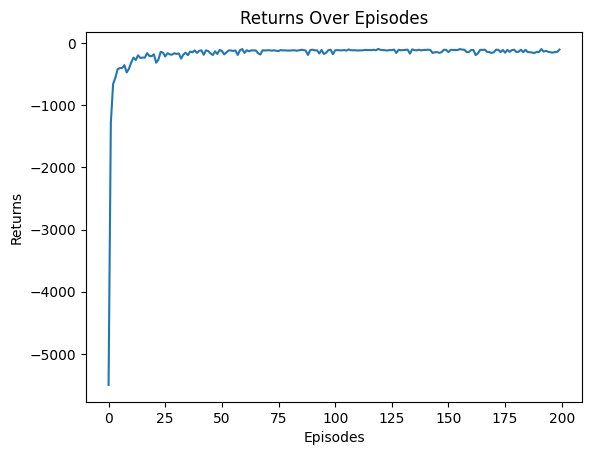

In [100]:
import matplotlib.pyplot as plt

plt.plot(np.arange(episodes), returns)
plt.title("Returns Over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.show()

## Run Greedily On An Example

In [101]:
# Run the algorithm in inferencing mode and 
# observe its performance
env = gym.make(env_type, render_mode="human")
state, info = env.reset(seed=64)
G = 0
num_steps = 0
terminated = False

while not terminated:
    estimated_returns = predict_returns(state, Q)
    action = np.argmax(estimated_returns) 
    state, reward, terminated, truncated, info = env.step(action)
    G += reward
    num_steps += 1

print(f'Total Reward: {G}, Steps Taken: {num_steps}')

env.close()

Total Reward: -86.0, Steps Taken: 86
